# Bayesian Data Analysis
## PPCA with priors on weights in Stan
Illustration of PPCA using Stan for parameter estimation and automatic relevance determination

In [1]:
import numpy as np
import pystan
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import linalg
import copy
# edit default plot settings (colours from colorbrewer2.org)
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('lines', color='#377eb8', linewidth=2)
plt.rc('axes', color_cycle=('#377eb8','#e41a1c','#4daf4a',
                            '#984ea3','#ff7f00','#ffff33'))

/Users/nbip/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Now we introduce an independent Gaussian prior on each column of the weights. Each gaussian has a precision hyperparameter $\alpha_i$ so that

\begin{equation}
p(W|\alpha) = \prod_{i=1}^M \left( \frac{\alpha_i}{2\pi} \right)^{D/2} \exp{-\frac{1}{2}\alpha_i w_i^Tw_i}
\end{equation}

So now we are trying to infer 

$$p(W,\alpha | y)$$

where we can marginalize for $W$ or $\alpha$ and the $\alpha$'s will tell us something about the sparsity of the problem

In [2]:
class createData:
    'documentation'
    
    def __init__(self,d,dl,n,mu,sigma2):
        # sample latent variable Z
        self.Z = np.random.multivariate_normal(np.zeros(dl),np.identity(dl),n).T  # dl x n    

        # create additive noise
        noise = np.random.multivariate_normal(np.zeros(d),sigma2*np.identity(d),n).T  # d x n
        
        # create orthogonal signal directions
        self.W = linalg.orth(np.random.random((d,dl)))  # d x dl

        # data-space data
        self.Y = np.dot(self.W,self.Z) + noise;
        
        
    def removeData(self,m):
        # copy of original data
        y_miss = copy.copy(self.Y)
        # indicator matrix, 1 for present, 0 for missing
        S = np.ones((d,n))        
        
        # matrix of uniformly distributed random numbers
        r = np.random.uniform(0,1,(d,n))
        
        # boolean of those lower than specified missing rate
        bol = r<m
        
        # set entries to nan as specified by bol
        y_miss[bol] = np.nan
        S[bol] = 0
        
        return dict(y_miss=y_miss,S=S)

In [3]:
d=3
dl=1      # number of true latent variable dimensions
k=2       # number of latent variable dimensions in the model
n=500
mu=np.zeros(d)
sigma2=0.05

datObj = createData(d,dl,n,mu,sigma2)
# extract quantities
W = datObj.W
Z = datObj.Z
Y = datObj.Y

## Stan model with priors on weights

In [4]:
# =============== PPCA model with priors on weights ===================
ppca_prior_code = """
data {
  int<lower=1> N;             // num datapoints
  int<lower=1> D;              // num dimension
  int<lower=1> K;              // num basis
  real<lower=0> ones;
  real y[D,N];
}
transformed data {
  matrix[K,K] Sigma;
  vector<lower=0>[K] diag_elem;
  vector<lower=0>[K] zr_vec;
  for (k in 1:K) zr_vec[k] <- 0;
  for (k in 1:K) diag_elem[k] <- ones;
  Sigma <- diag_matrix(diag_elem);
}
parameters {
  matrix[D,K] A;            // basis
  vector[K] x[N];           // coefficients
  real<lower=0> sigma;      // noise variance
  vector<lower=0>[K] alpha; // prior on weights
}
model {  
  
  for (i in 1:N)
      x[i] ~ multi_normal(zr_vec, Sigma);
      
  for (d in 1:D)
    for (k in 1:K)
      A[d,k] ~ normal(0, alpha[k]);
  
  for (i in 1:N)
    for (d in 1:D)
      //y[d,i] ~ normal(dot_product(row(A, d), x[i]), sigma);
      increment_log_prob(normal_log(y[d,i], dot_product(row(A, d), x[i]), sigma));
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N)
       for (d in 1:D)
        log_lik[n] <- normal_log(y[d,n], dot_product(row(A, d), x[n]), sigma);
}
"""
data = dict(N=n, D=d, K=k, ones=1, 
            y=Y)
fit = pystan.stan(model_code=ppca_prior_code, data=data)
print(fit)
samples = fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b9a1b20597fd32487b29e390b6079fd NOW.


Inference for Stan model: anon_model_8b9a1b20597fd32487b29e390b6079fd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A[0,0]         0.07    0.16   0.22  -0.28  -0.17   0.16   0.27   0.29      2   9.34
A[1,0]         0.07    0.16   0.23   -0.3  -0.17   0.17   0.28    0.3      2   12.3
A[2,0]         0.24    0.55   0.78  -0.98  -0.52   0.53   0.94   0.99      2  21.45
A[0,1]         0.06    0.09   0.12   -0.1  -0.02   0.01   0.19   0.28      2   3.09
A[1,1]         0.07    0.09   0.13  -0.09  -0.02   0.01    0.2   0.29      2   3.72
A[2,1]         0.22     0.3   0.42  -0.21  -0.03   0.01   0.58   0.98      2   5.62
x[0,0]        -0.15    0.38   0.75  -1.33  -0.67   -0.4   0.51   1.35      4   1.39
x[1,0]         0.12    0.34   0.67  -1.32  -0.42   0.32   0.59   1.18      4   1.33
x[2,0]         0.06    0.17   0.58  -1.36  -0.23   0.11

In [10]:
alpha = samples['alpha']
alpha_sorted = np.sort(alpha)

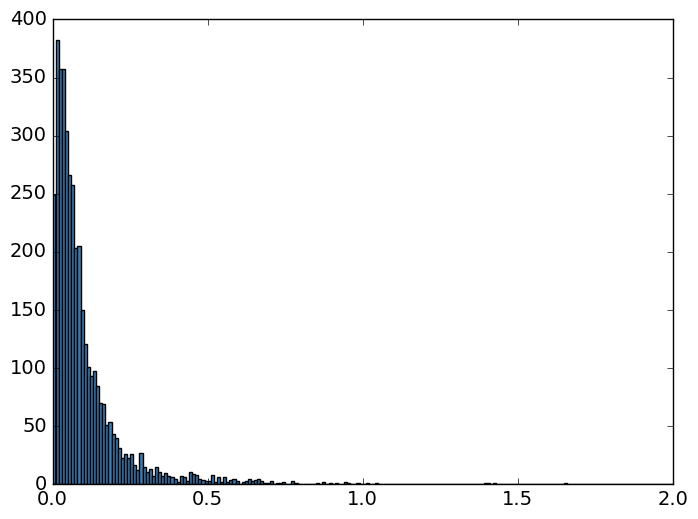

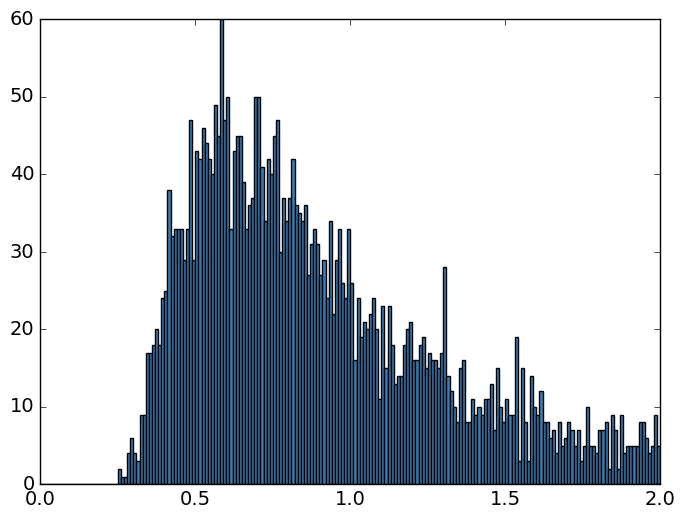

In [11]:
binwidth = 0.01

for i in range(0,k):
    plt.hist(alpha_sorted[:,i],bins=np.arange(0.0, 2.0+binwidth, binwidth))
    axes = plt.gca()
    axes.set_xlim([0,2])
    plt.show()

## Transformation matrix (principal components)

In [17]:
A = samples['A']

ix = np.argsort(alpha)
B = np.zeros(A.shape)
for i in range(0,len(A)):
    B[i,:,:] = A[i,:,ix[i,:]].T
    
W_est = np.mean(abs(B[:,:,1]),axis=0)
W_est

array([ 0.26300719,  0.27606312,  0.92516899])

In [18]:
W

array([[ 0.23519838],
       [ 0.26443237],
       [ 0.93528458]])

In [13]:
# the maximum alpha value and index
ma = np.max(alpha[0,:])
ix = np.argmax(alpha[0,:])
ix

0

In [14]:
# the correspnding weight vector
W_est = A[0,:,ix]
W_est

array([-0.24787767, -0.25626386, -0.8821819 ])

In [15]:
W

array([[ 0.23519838],
       [ 0.26443237],
       [ 0.93528458]])

<Container object of 3 artists>

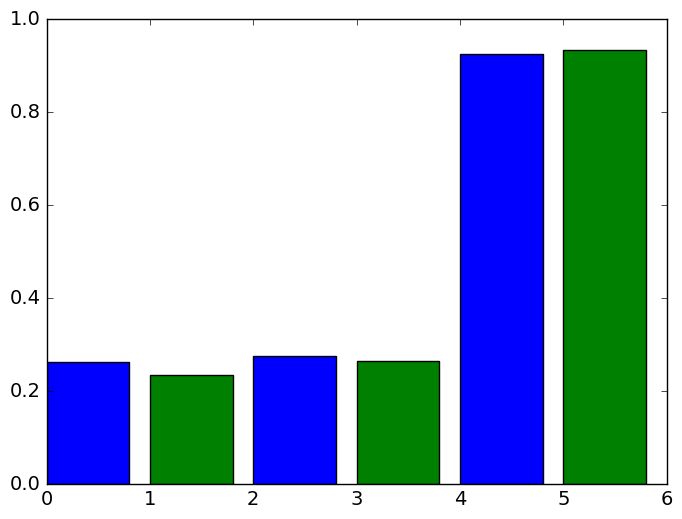

In [19]:
plt.bar(range(0,2*len(W_est),2),abs(W_est))
plt.bar(range(1,2*len(W)+1,2),W,color='g');

## Noise variance

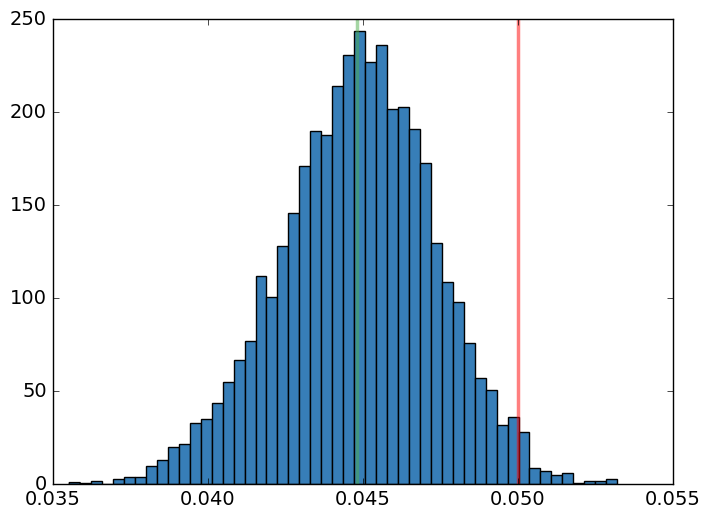

In [20]:
tmp = samples['sigma']
sigma = [x*x for x in tmp];
s2 = np.mean(sigma)
plt.hist(sigma,50)
plt.axvline(s2, color='#4daf4a', linewidth=2.5, alpha=0.5)
plt.axvline(sigma2, color='#ff0000', linewidth=2.5, alpha=0.5);

## Horseshoe prior

We now change the prior from the independent Gaussians with hyperparameter $\alpha$ to

$$
w_i | \lambda_i, \tau \sim N(0,\lambda_i^2\tau^2 I)\\
\lambda_i \sim C^+(0,1)
$$

There is a global shrinkage parameter $\tau$ that shrinks all the parameters towards zero and then there is a local shrinkage parameter $\lambda_i$, individual to each weight column, which allows some weights $w_i$ to escape this shrinkage.

The global shrinkage parameter could also be drawn from a half-cauchy distribution, though this might be suboptimal

$$
\tau \sim C^+(0,1)
$$




In [21]:
# =============== PPCA model with priors on weights ===================
ppca_prior_code = """
data {
  int<lower=1> N;             // num datapoints
  int<lower=1> D;              // num dimension
  int<lower=1> K;              // num basis
  real<lower=0> ones;
  real y[D,N];
}
transformed data {
  matrix[K,K] Sigma;
  vector<lower=0>[K] diag_elem;
  vector<lower=0>[K] zr_vec;
  for (k in 1:K) zr_vec[k] <- 0;
  for (k in 1:K) diag_elem[k] <- ones;
  Sigma <- diag_matrix(diag_elem);
}
parameters {
  matrix[D,K] A;             // basis
  vector[K] x[N];            // coefficients
  real<lower=0> sigma;       // noise variance
  vector<lower=0>[K] lambda; // the local prior on the weights
  real<lower=0> tau;         // the global prior on the weights        
}
model {  
  
  lambda ~ cauchy(0,1);
  tau ~ cauchy(0,1);
  
  for (i in 1:N)
      x[i] ~ multi_normal(zr_vec, Sigma);
      
  for (d in 1:D)
    for (k in 1:K)
      A[d,k] ~ normal(0, lambda[k]*lambda[k]*tau*tau);
  
  for (i in 1:N)
    for (d in 1:D)
      //y[d,i] ~ normal(dot_product(row(A, d), x[i]), sigma);
      increment_log_prob(normal_log(y[d,i], dot_product(row(A, d), x[i]), sigma));
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N)
       for (d in 1:D)
        log_lik[n] <- normal_log(y[d,n], dot_product(row(A, d), x[n]), sigma);
}
"""
data = dict(N=n, D=d, K=k, ones=1, 
            y=Y)
fit = pystan.stan(model_code=ppca_prior_code, data=data)
print(fit)
samples = fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26055bc017595d46b1403d50d9da5456 NOW.


Inference for Stan model: anon_model_26055bc017595d46b1403d50d9da5456.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A[0,0]        -0.07    0.08   0.12  -0.28  -0.19-5.4e-3 4.3e-3   0.08      2   4.15
A[1,0]        -0.07    0.09   0.13   -0.3  -0.17-2.3e-3 7.5e-3   0.07      2   5.89
A[2,0]        -0.23    0.29   0.41  -0.98  -0.54-2.9e-3 9.4e-3   0.14      2  11.18
A[0,1]          0.2    0.08   0.12  -0.05   0.18   0.26   0.27   0.29      2   5.03
A[1,1]         0.21    0.09   0.13  -0.05   0.17   0.28   0.29   0.31      2   6.45
A[2,1]          0.7    0.29   0.41  -0.08   0.47   0.93   0.95    1.0      2   11.0
x[0,0]          0.1    0.23   0.91  -1.92  -0.46   0.29   0.69   1.76     16   1.07
x[1,0]        -0.13    0.01   0.88  -1.83  -0.65  -0.31   0.41   1.84   4000   1.04
x[2,0]        -0.08    0.01   0.86  -1.81  -0.51  -0.19

In [22]:
tau = samples['tau']
lamb = samples['lambda']
A = samples['A']

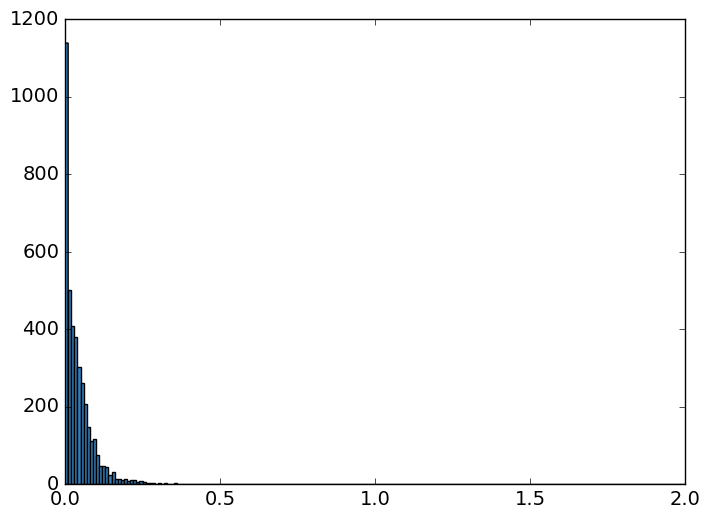

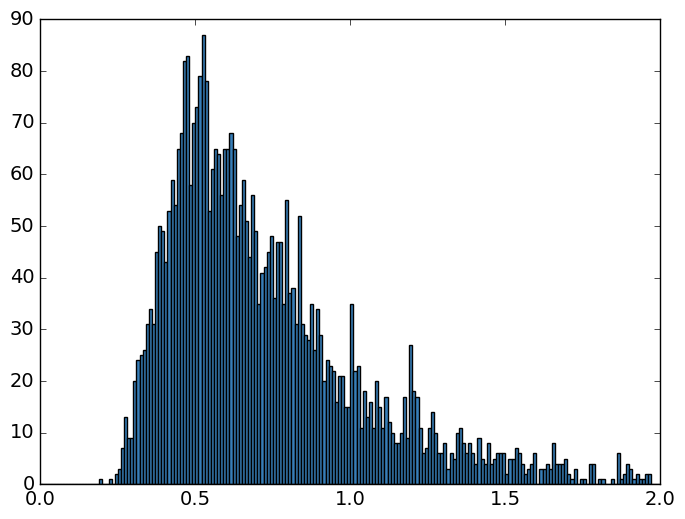

In [30]:
ix = np.argsort(alpha)
lambda_sorted = np.sort(lamb)
binwidth = 0.01

for i in range(0,k):
    plt.hist(tau*tau*lambda_sorted[:,i]*lambda_sorted[:,i],bins=np.arange(0.0, 2.0+binwidth, binwidth))
    axes = plt.gca()
    axes.set_xlim([0,2])
    plt.show()




# Sort the weights according to their shrinkage

In [32]:
shrinkage = np.zeros(lamb.shape)

for i in range(0,len(lamb)):
    shrinkage[i,:] = tau[i]*tau[i]*lamb[i,:]*lamb[i,:]

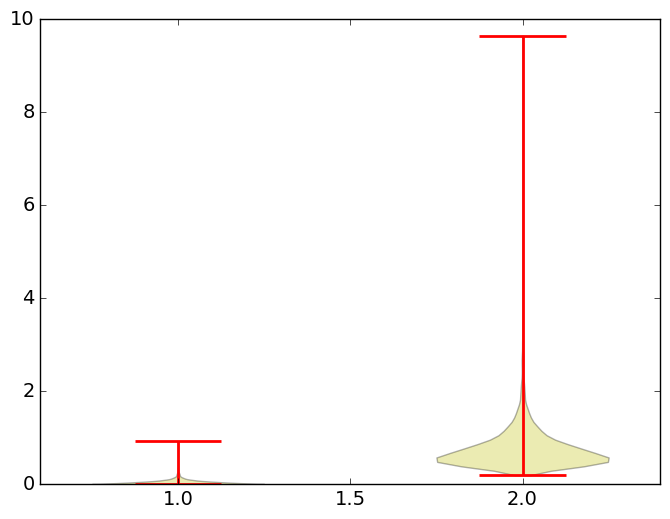

In [33]:
ix = np.argsort(shrinkage)
shrinkage_sorted = np.sort(shrinkage)
plt.violinplot(shrinkage_sorted);

In [34]:
B = np.zeros(A.shape)
for i in range(0,len(A)):
    B[i,:,:] = A[i,:,ix[i,:]].T

In [35]:
W_est = np.mean(abs(B[:,:,1]),axis=0)
W_est

array([ 0.26665291,  0.2806855 ,  0.93848486])

In [36]:
W

array([[ 0.23519838],
       [ 0.26443237],
       [ 0.93528458]])

## how do the estimated weights, with the lowest shrinkage, compare to the true weights?

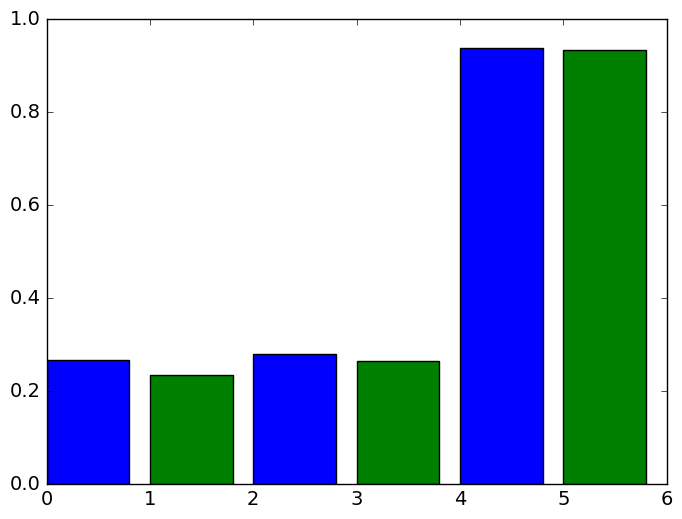

In [39]:
plt.bar(range(0,2*len(W_est),2),abs(W_est))
plt.bar(range(1,2*len(W)+1,2),W,color='g');

## how does the weights with the most shrinkage compare to the true weights?

In [40]:
W_another = np.mean(abs(B[:,:,0]),axis=0)
W_another

array([ 0.02603572,  0.02042145,  0.03560175])

<Container object of 3 artists>

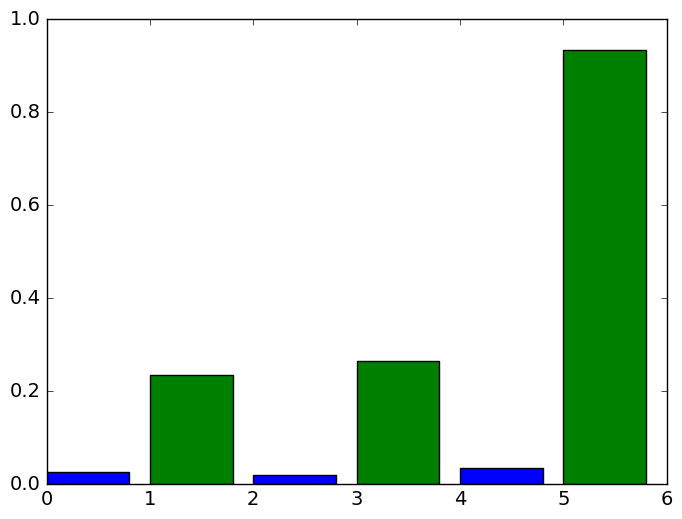

In [41]:
plt.bar(range(0,2*len(W_another),2),abs(W_another))
plt.bar(range(1,2*len(W)+1,2),W,color='g')